## Homework

In [1]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [57]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from PIL import Image

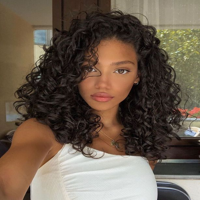

In [5]:
#test image

load_data = 'data/'

img = Image.open(f'{load_data}/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')
img.resize((200, 200))

In [6]:
import os
from torch.utils.data import Dataset

class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [59]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the size after conv and pooling: ((200-3+1)/2) = 99. So, 32x99x99
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.out_act = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = self.conv(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        x = self.out_act(x)
        return x

# Instantiate the model
model = SimpleCNN()
model.to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

criterion = nn.BCEWithLogitsLoss()


In [60]:
# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
           Sigmoid-8                    [-1, 1]               0
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------
Total parameters: 20073473


In [61]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [62]:
from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir=f'{load_data}/train',
    transform=train_transforms
)

test_dataset = HairDataset(
    data_dir=f'{load_data}/test',
    transform=train_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [63]:
model

SimpleCNN(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [64]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(test_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6731, Acc: 0.4869, Val Loss: 0.6763, Val Acc: 0.4876
Epoch 2/10, Loss: 0.6560, Acc: 0.4869, Val Loss: 0.6925, Val Acc: 0.4876
Epoch 3/10, Loss: 0.6436, Acc: 0.4869, Val Loss: 0.6644, Val Acc: 0.4876
Epoch 4/10, Loss: 0.6303, Acc: 0.4869, Val Loss: 0.6507, Val Acc: 0.4876
Epoch 5/10, Loss: 0.6387, Acc: 0.5019, Val Loss: 0.6597, Val Acc: 0.4876
Epoch 6/10, Loss: 0.6430, Acc: 0.4906, Val Loss: 0.6562, Val Acc: 0.4925
Epoch 7/10, Loss: 0.6201, Acc: 0.4894, Val Loss: 0.6626, Val Acc: 0.4876
Epoch 8/10, Loss: 0.6161, Acc: 0.4881, Val Loss: 0.6557, Val Acc: 0.4876
Epoch 9/10, Loss: 0.6056, Acc: 0.4881, Val Loss: 0.6538, Val Acc: 0.4925
Epoch 10/10, Loss: 0.5994, Acc: 0.4881, Val Loss: 0.6619, Val Acc: 0.4876


In [78]:
history

{'acc': [0.4868913857677903,
  0.4868913857677903,
  0.4868913857677903,
  0.4868913857677903,
  0.50187265917603,
  0.49063670411985016,
  0.4893882646691635,
  0.48813982521847693,
  0.48813982521847693,
  0.48813982521847693],
 'loss': [0.6730541421679522,
  0.6560353481218907,
  0.6436111261410065,
  0.6303375447436367,
  0.6387351911315013,
  0.6429983813887679,
  0.6200886336754026,
  0.6160644453563048,
  0.6055630310421133,
  0.5994442754172803],
 'val_acc': [0.48756218905472637,
  0.48756218905472637,
  0.48756218905472637,
  0.48756218905472637,
  0.48756218905472637,
  0.4925373134328358,
  0.48756218905472637,
  0.48756218905472637,
  0.4925373134328358,
  0.48756218905472637],
 'val_loss': [0.6762967954820661,
  0.6925341390555178,
  0.6644291940020092,
  0.6506524713181737,
  0.659725187874552,
  0.656241253982136,
  0.6626263761994851,
  0.655709253170004,
  0.653834348146002,
  0.6618860435129991]}

In [65]:
import numpy as np

In [71]:
#Question 3. Median of training accuracy for all the epochs (1 point)

np.median(history['acc'])

np.float64(0.48813982521847693)

In [73]:
#Question 4. Standard deviation of training loss for all the epochs (1 point)
np.std(history['loss'])

np.float64(0.02172128409068609)

In [74]:
#Question 5. Mean of test loss for all the epochs (1 point)
np.mean(history['val_loss'])

np.float64(0.6633935062742945)

In [77]:
# Question 6. Average of test accuracy for the last 5 epochs (1 point)
np.mean(history['val_acc'][-5:])

np.float64(0.48955223880597015)

In [ ]:
# Dataagumentaion
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [10]:
import os
from torch.utils.data import Dataset

class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [14]:
from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir=f'{load_data}/train',
    transform=train_transforms
)

test_dataset = HairDataset(
    data_dir=f'{load_data}/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
#

import torch.nn as nn

class HairClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(HairClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [17]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HairClassifierMobileNet(num_classes=10)
model.to(device);

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [20]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in test_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(test_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 0.4772, Train Acc: 0.7940
  Val Loss: 0.1247, Val Acc: 0.9453
Epoch 2/10
  Train Loss: 0.1220, Train Acc: 0.9401
  Val Loss: 0.2910, Val Acc: 0.9154
Epoch 3/10
  Train Loss: 0.2368, Train Acc: 0.9051
  Val Loss: 0.1076, Val Acc: 0.9701
Epoch 4/10
  Train Loss: 0.3248, Train Acc: 0.9189
  Val Loss: 0.1822, Val Acc: 0.9552
Epoch 5/10
  Train Loss: 0.7646, Train Acc: 0.8901
  Val Loss: 0.0395, Val Acc: 0.9751
Epoch 6/10
  Train Loss: 0.9372, Train Acc: 0.8602
  Val Loss: 0.0255, Val Acc: 0.9950
Epoch 7/10
  Train Loss: 0.3516, Train Acc: 0.9338
  Val Loss: 0.0337, Val Acc: 0.9900
Epoch 8/10
  Train Loss: 0.2412, Train Acc: 0.9638
  Val Loss: 0.0207, Val Acc: 0.9900
Epoch 9/10
  Train Loss: 0.4867, Train Acc: 0.9189
  Val Loss: 0.0400, Val Acc: 0.9900
Epoch 10/10
  Train Loss: 0.5737, Train Acc: 0.9101
  Val Loss: 0.0092, Val Acc: 0.9950


## Mejora

In [29]:
import torch.nn as nn

class HairClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(HairClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x


In [30]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, 
                       num_epochs, device, learning_rate):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'model/hair/hair_v4_{learning_rate}_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [31]:
def make_model(learning_rate=0.01):
    model = HairClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [32]:
for lr in [0.001, 0.1, 0.01, 0.1]:
  print("learning rate =", lr)
  model, optimizer = make_model(lr)
  train_and_evaluate(model, optimizer, train_loader, test_loader, criterion, num_epochs, device, lr)
  print("*************")
  print()

learning rate = 0.001
Epoch 1/10
  Train Loss: 0.6285, Train Acc: 0.7603
  Val Loss: 0.1735, Val Acc: 0.9502
Checkpoint saved: model/hair/hair_v4_0.001_01_0.950.pth
Epoch 2/10
  Train Loss: 0.2811, Train Acc: 0.8777
  Val Loss: 0.1346, Val Acc: 0.9552
Checkpoint saved: model/hair/hair_v4_0.001_02_0.955.pth
Epoch 3/10
  Train Loss: 0.2124, Train Acc: 0.9376
  Val Loss: 0.0801, Val Acc: 0.9851
Checkpoint saved: model/hair/hair_v4_0.001_03_0.985.pth
Epoch 4/10
  Train Loss: 0.1401, Train Acc: 0.9551
  Val Loss: 0.0556, Val Acc: 0.9851
Epoch 5/10
  Train Loss: 0.1269, Train Acc: 0.9576
  Val Loss: 0.0568, Val Acc: 0.9851
Epoch 6/10
  Train Loss: 0.1698, Train Acc: 0.9463
  Val Loss: 0.0622, Val Acc: 0.9751
Epoch 7/10
  Train Loss: 0.2368, Train Acc: 0.9064
  Val Loss: 0.0564, Val Acc: 0.9851
Epoch 8/10
  Train Loss: 0.1369, Train Acc: 0.9563
  Val Loss: 0.0441, Val Acc: 0.9900
Checkpoint saved: model/hair/hair_v4_0.001_08_0.990.pth
Epoch 9/10
  Train Loss: 0.0842, Train Acc: 0.9750
  Val L

In [ ]:
num_epochs = 50

model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2,
)

train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

## 8.10 Data augmentation

* Different data augmentations
* Training a model with augmentations
* How to select data augmentations?

In [38]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: './clothing-dataset-small/train'

In [ ]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

In [ ]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## 8.11 Training a larger model

* Train a 299x299 model

In [ ]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
input_size = 299

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

## 8.12 Using the model

* Loading the model
* Evaluating the model
* Getting predictions

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

In [ ]:
model = keras.models.load_model('xception_v4_1_13_0.903.h5')

In [ ]:
model.evaluate(test_ds)

In [ ]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [ ]:
img = load_img(path, target_size=(299, 299))

In [ ]:
import numpy as np

In [ ]:
x = np.array(img)
X = np.array([x])
X.shape

In [ ]:
X = preprocess_input(X)

In [ ]:
pred = model.predict(X)

In [ ]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [ ]:
dict(zip(classes, pred[0]))

## 8.13 Summary

* We can use pre-trained models for general image classification
* Convolutional layers let us turn an image into a vector
* Dense layers use the vector to make the predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150) before training a big one (299x299)
* Learning rate - how fast the model trians. Fast learners aren't always best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation

## 8.14 Explore more

* Add more data, e.g. Zalando, etc (ADD LINKS)
* Albumentations - another way of generating augmentations
* Use PyTorch or MXNet instead of TensorFlow/Keras
* In addition to Xception, there are others architectures - try them 

Other projects:

* cats vs dogs
* Hotdog vs not hotdog
* Category of images

